Tidy Tuesday dataset from [2018/05/21](https://github.com/rfordatascience/tidytuesday/tree/master/data/2018) about honey production.
Exercise in data wrangling, trying to reproduce this [table](https://www.beeculture.com/wp-content/uploads/2017/04/1blue2.png) 
for [this page](https://www.beeculture.com/u-s-honey-industry-report-2016/).

The dataset seems incomplete and the data doesn't seem consistent either.

In [1]:
using DataFrames, DataFramesMeta, CSV, Chain, FreqTables, StatsBase
ENV["COLUMNS"] = 1000  # set column width

1000

In [2]:
df = CSV.read(
    "honeyproduction.csv",
    DataFrame
);

In [4]:
keep = ["year", "state", "numcol", "totalprod"]
cols = ["totalprod", "numcol"];

In [5]:
year_filtered = @chain df begin
    @rsubset(:year ∈ (2010:2012))
end;

t = select(year_filtered, keep)
t = @chain t begin
    sort(["year", "totalprod"], rev=true)
    groupby("year")
    combine(_, x -> first(x, 10))
end
t[!, cols] ./= 1000;

In [6]:
function specify(el; suffix)
    if tryparse(Int64, el) == nothing
        return el
    else
        return "$(el)_$(suffix)"
    end
end

specify (generic function with 1 method)

In [7]:
pivs = Dict()

for col in cols
    pivs[col] = unstack(t, "state", "year", col)
    rename!(x-> specify(x; suffix=col), pivs[col])
    
end

In [8]:
col_order = []
for pair in zip(names.(values(pivs))...)
    i, j = pair
    if i ∉ col_order
        push!(col_order, i)
    end
    if j ∉ col_order
        push!(col_order, j)
    end
end

In [9]:
# I decided to keep the states consistent over time, instead of just concatenating and sorting the top 10 from each year.
leftjoin(values(pivs)..., on=:state)[!, col_order]

11×7 DataFrame
 Row │ state    2010_totalprod  2010_numcol  2011_totalprod  2011_numcol  2012_totalprod  2012_numcol 
     │ String3  Float64?        Float64?     Float64?        Float64?     Float64?        Float64?    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ ND              46410.0        510.0         32660.0        460.0         33120.0        480.0
   2 │ CA              27470.0        410.0         17760.0        370.0         11550.0        330.0
   3 │ SD              15370.0        265.0         16500.0        250.0         16380.0        260.0
   4 │ FL              13800.0        200.0         10980.0        180.0         12352.0        193.0
   5 │ MT              11618.0        157.0         13340.0        145.0          7540.0        145.0
   6 │ MN               8448.0        128.0          6360.0        120.0          8375.0        125.0
   7 │ TX               7200.0        100.0          4524.0         78.0          4784.0         92.0
   8 │ MI               4118.0         71.0          4736.0         74.0          4161.0         73.0
   9 │ WI               4096.0         64.0          3591.0         57.0          4140.0         60.0
  10 │ LA               2880.0         36.0       missing      missing            3526.0         41.0
  11 │ ID            missing      missing            3132.0         87.0       missing      missing   

In [13]:
using PlotlyJS
# trying out plotting in julia

In [104]:
function custom_plot(pdf)
    traces = []
    for col in cols
        temp = @chain pdf begin
            scatter(
                mode="lines", 
                x = :year,
                y = col,
                group = :state
            )
        end
        push!(traces, temp)
    end;

    # https://community.plotly.com/t/how-to-use-plotconfig-with-make-subplots/58137
    fig = PlotlyJS.make_subplots(rows=1, cols=2)

    for tuple_to_unpack in zip(traces, [(1,1), (1,2)]) 
        group_trace, (row, col) = tuple_to_unpack
        for trace in group_trace
            add_trace!(fig, trace, row=row, col=col)
        end
    end

    relayout!(fig, width=700, height=400)

    # Lacks color consistency
    pl = plot([fig.plot.data...], # replaced with ellipses
               fig.plot.layout, 
               config=PlotConfig(displayModeBar=true))
    return pl
end

custom_plot (generic function with 1 method)

# Separately sorted

In [76]:
pdf = df[!, ["year", "state", "numcol", "yieldpercol"]]; #[p]lot_[df]
pdf[!, :numcol] ./= 1000;

# get top 10 of each year
pdf = @chain pdf begin
    sort(["year", "numcol"], rev=[false, true])
    groupby("year")
    combine(_, x-> first(x, 10))
end;

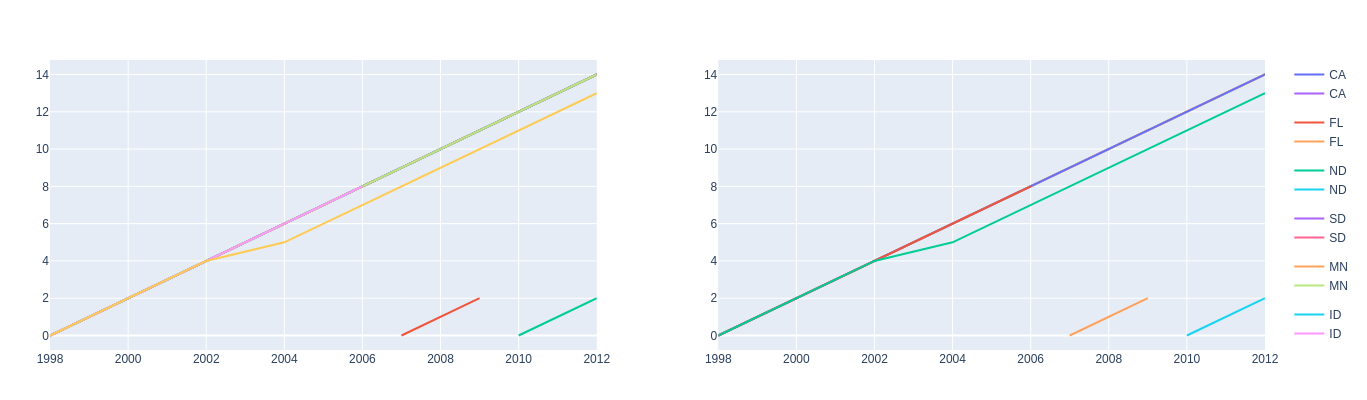

In [105]:
custom_plot(pdf)

# Total prod sort

In [98]:
p2f = df[!, ["year", "state", "numcol", "yieldpercol", "totalprod"]]; # [p]lot_[df][2]

In [107]:
p2f = @chain p2f begin
    sort(["year", "totalprod"], rev=[false, true])
    groupby("year")
    combine(x->first(x,10))
end;

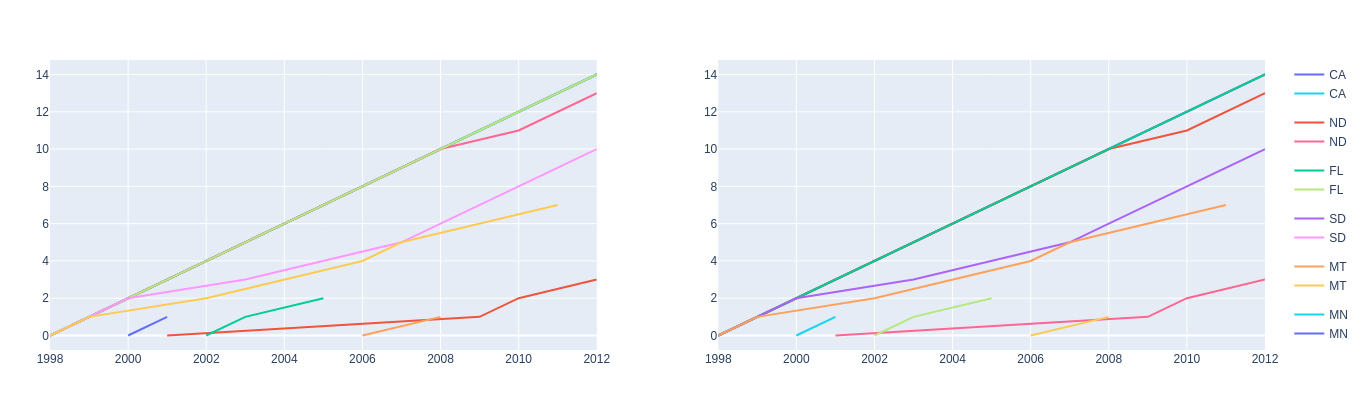

In [106]:
custom_plot(p2f)